In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# -----------------------------
# 1. Configuration and Data Loading
# -----------------------------
latitude_map = {
    "AT": 47.5,  "BE": 50.8,  "CH": 46.8,  "DE-LU": 51.2,
    "DK1": 55.0, "DK2": 56.0, "FI": 61.0,  "FR": 46.2,
    "GB": 54.0,  "NL": 52.4, "NO1": 59.9, "NO2": 63.4,
    "NO3": 58.0, "NO4": 65.0, "NO5": 58.9,
    "PL": 52.2,  "SE1": 59.3, "SE2": 61.0, "SE3": 57.7, "SE4": 55.6
}
COUNTRIES = [
    "AT", "BE", "CH", "DE-LU", "DK1", "DK2", "FI", "FR", "GB",
    "NL", "NO1", "NO2", "NO3", "NO4", "NO5", "PL",
    "SE1", "SE2", "SE3", "SE4"
]
BASE_URL = (
    "https://raw.githubusercontent.com/"
    "tvanlaerhoven/epex-client/main/data/"
)
LOCAL_RAW_DIR = r"D:\projects\energy_elec_anal\data\raw"
MERGED_DATA_PATH = os.path.join(LOCAL_RAW_DIR, "energy_price_merged_data.csv")


def load_data(countries, base_url, local_dir):
    os.makedirs(local_dir, exist_ok=True)
    dfs = []
    for c in countries:
        filename = f"{c}.csv"
        local_path = os.path.join(local_dir, filename)
        remote_url = f"{base_url}{filename}"
        if not os.path.isfile(local_path):
            try:
                df_temp = pd.read_csv(remote_url)
                df_temp.to_csv(local_path, index=False)
                print(f"Downloaded and saved {filename} to local raw directory.")
            except Exception as e:
                print(f"Failed to download {filename}: {e}")
                continue
        df = pd.read_csv(local_path)
        df["Country"] = c
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(MERGED_DATA_PATH, index=False)
    combined['Date'] = pd.to_datetime(combined['Date'], format="%Y-%m-%d")
    return combined

# -----------------------------
# 2. Data Preparation (wide -> long + datetime)
# -----------------------------

def prepare_long(df):
    hour_cols = [col for col in df.columns if col not in ['Date', 'Country', 'Baseload', 'Peakload']]
    df_long = df.melt(
        id_vars=['Date', 'Country'],
        value_vars=hour_cols,
        var_name='Hour',
        value_name='Price'
    )
    df_long['Price'] = pd.to_numeric(df_long['Price'], errors='coerce')
    df_long.dropna(inplace=True)

    # Clean Hour format: '00-01' -> '00:00'
    df_long['Hour'] = df_long['Hour'].str.extract(r'(\d{2})')[0] + ':00'

    # Create datetime column
    df_long['datetime'] = pd.to_datetime(
        df_long['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_long['Hour'],
        format='%Y-%m-%d %H:%M'
    )
    return df_long




raw = load_data(COUNTRIES, BASE_URL, LOCAL_RAW_DIR)
df_long = prepare_long(raw)
df_long.head()
df_long['Latitude'] = df_long['Country'].map(latitude_map)
df_long.head()

In [ ]:



df_long.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

url = "https://raw.githubusercontent.com/AZFARHAD24511/datasets/main/energy_price_merged_data.csv"
raw = pd.read_csv(url)
raw['Date'] = pd.to_datetime(raw['Date'], format="%Y-%m-%d")
df_long = prepare_long(raw)
# --- 1. آماده‌سازی دیتافریم مدلینگ ---
df_rf = df_long.copy()

# 1.a) نگاشت Latitude (خط اصلی)
df_rf['Latitude'] = df_rf['Country'].map(latitude_map)

# 1.b) حذف ردیف‌های ناقص
df_rf = df_rf.dropna(subset=['Latitude', 'Price'])

# 1.c) تبدیل Hour به One-Hot
df_rf = pd.get_dummies(df_rf, columns=['Hour'], drop_first=True)

# بررسی ابعاد پس از پیش‌پردازش
print("Shape after preprocessing:", df_rf.shape)

# --- 2. تعریف X و y ---
y = df_rf['Price']
X = df_rf.drop(columns=['Date', 'Country', 'Price', 'datetime'])  # اگر ستون datetime دارید هم حذف کنید

# --- 3. تقسیم‌بندی داده (Train/Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- ادامه‌ی کد مشابه قبلی ---
# --- 4. برازش Random Forest ---
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- 5. ارزیابی مدل ---
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest R²: {r2:.3f}")
print(f"Random Forest MAE: {mae:.2f}")

# --- 6. اهمیت ویژگی‌ها ---
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(10)

# رسم اهمیت ۱۰ ویژگی برتر
plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 10 Features in Random Forest')
plt.tight_layout()
plt.show()


In [ ]:
importances.sort_values(ascending=False).head(10)

Shape after preprocessing: (85920, 28)
Random Forest R²: 0.466
Random Forest MAE: 26.11


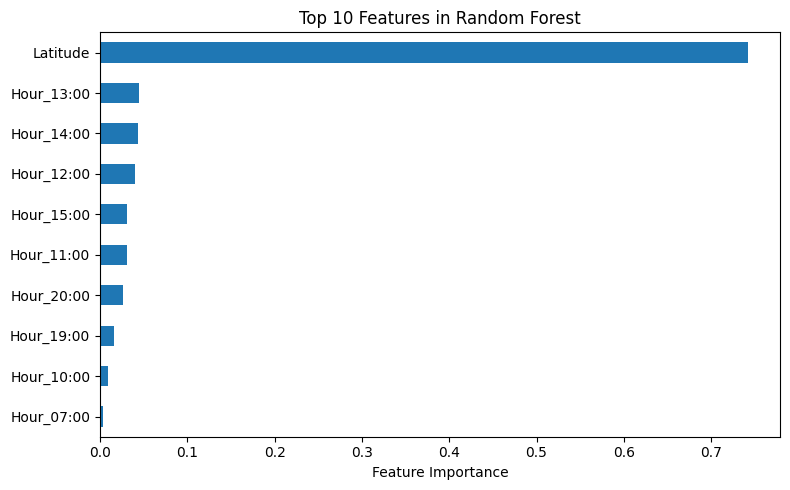

In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
# -----------------------------
# 1. Configuration and Data Loading
# -----------------------------
latitude_map = {
    "AT": 47.5,  "BE": 50.8,  "CH": 46.8,  "DE-LU": 51.2,
    "DK1": 55.0, "DK2": 56.0, "FI": 61.0,  "FR": 46.2,
    "GB": 54.0,  "NL": 52.4, "NO1": 59.9, "NO2": 63.4,
    "NO3": 58.0, "NO4": 65.0, "NO5": 58.9,
    "PL": 52.2,  "SE1": 59.3, "SE2": 61.0, "SE3": 57.7, "SE4": 55.6
}



COUNTRIES = [
    "AT", "BE", "CH", "DE-LU", "DK1", "DK2", "FI", "FR", "GB",
    "NL", "NO1", "NO2", "NO3", "NO4", "NO5", "PL",
    "SE1", "SE2", "SE3", "SE4"
]
BASE_URL = (
    "https://raw.githubusercontent.com/"
    "tvanlaerhoven/epex-client/main/data/"
)
LOCAL_RAW_DIR = r"D:\projects\energy_elec_anal\data\raw"
MERGED_DATA_PATH = os.path.join(LOCAL_RAW_DIR, "energy_price_merged_data.csv")


def load_data(countries, base_url, local_dir):
    os.makedirs(local_dir, exist_ok=True)
    dfs = []
    for c in countries:
        filename = f"{c}.csv"
        remote_url = f"{base_url}{filename}"
        df = pd.read_csv(remote_url)
        df["Country"] = c
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(MERGED_DATA_PATH, index=False)
    combined['Date'] = pd.to_datetime(combined['Date'], format="%Y-%m-%d")
    return combined

def load_data(countries, base_url, local_dir):
    os.makedirs(local_dir, exist_ok=True)
    dfs = []
    for c in countries:
        filename = f"{c}.csv"
        local_path = os.path.join(local_dir, filename)
        remote_url = f"{base_url}{filename}"
        if not os.path.isfile(local_path):
            try:
                df_temp = pd.read_csv(remote_url)
                df_temp.to_csv(local_path, index=False)
                print(f"Downloaded and saved {filename} to local raw directory.")
            except Exception as e:
                print(f"Failed to download {filename}: {e}")
                continue
        df = pd.read_csv(local_path)
        df["Country"] = c
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(MERGED_DATA_PATH, index=False)
    combined['Date'] = pd.to_datetime(combined['Date'], format="%Y-%m-%d")
    return combined

# -----------------------------
# 2. Data Preparation (wide -> long + datetime)
# -----------------------------

def prepare_long(df):
    hour_cols = [col for col in df.columns if col not in ['Date', 'Country', 'Baseload', 'Peakload']]
    df_long = df.melt(
        id_vars=['Date', 'Country'],
        value_vars=hour_cols,
        var_name='Hour',
        value_name='Price'
    )
    df_long['Price'] = pd.to_numeric(df_long['Price'], errors='coerce')
    df_long.dropna(inplace=True)

    # Clean Hour format: '00-01' -> '00:00'
    df_long['Hour'] = df_long['Hour'].str.extract(r'(\d{2})')[0] + ':00'

    # Create datetime column
    df_long['datetime'] = pd.to_datetime(
        df_long['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_long['Hour'],
        format='%Y-%m-%d %H:%M'
    )
    return df_long

raw = load_data(COUNTRIES, BASE_URL, LOCAL_RAW_DIR)
raw.head()
raw['Date'] = pd.to_datetime(raw['Date'], format="%Y-%m-%d")
df_long = prepare_long(raw)
# convert wide to long dataframe
df_rf = df_long.copy()

# 1.a) add Latitude to data frame
df_rf['Latitude'] = df_rf['Country'].map(latitude_map)

# 1.b) na remove
df_rf = df_rf.dropna(subset=['Latitude', 'Price'])

# 1.c) One-Hot
df_rf = pd.get_dummies(df_rf, columns=['Hour'], drop_first=True)


print("Shape after preprocessing:", df_rf.shape)


y = df_rf['Price']
X = df_rf.drop(columns=['Date', 'Country', 'Price', 'datetime'])  # اگر ستون datetime دارید هم حذف کنید


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


# Random Forest ---
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# evaluation model
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest R²: {r2:.3f}")
print(f"Random Forest MAE: {mae:.2f}")

# features importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(10)

# top 10 immportance features
plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 10 Features in Random Forest')
plt.tight_layout()
plt.show()
